## Leaderboard benchmark 1: oneshot naive model
Let's start with an almost totally naive model and see where that gets us. The plan is to fill the submission file with the last known MBD value for each county and upload it.

This will give us a good idea of where we are starting and how our own internal cross validation relates to the score we can expect on the public leader board.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Build submission dataframe](#submission_dataframe)
4. [Sanity check](#sanity_check)
5. [Submission & results](#bmission_results)

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs

# Instantiate paths
paths = conf.DataFilePaths()

import pandas as pd
import matplotlib

print(f'Python: {sys.version}')
print()
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Pandas 1.4.3
Matplotlib: 3.6.3


<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count

<a name="load_inspect"></a>
### 2. Load & inspect

In [2]:
# Load up training file, set dtype for first day of month

training_df = pd.read_csv(f'{paths.KAGGLE_DATA_PATH}/updated_train.csv.zip', compression='zip')
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [3]:
# Load up test datafile, set dtype for first day of month
test_df = pd.read_csv(f'{paths.KAGGLE_DATA_PATH}/test.csv')
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


<a name="submission_dataframe"></a>
### 3. Build submission dataframe
One new wrinkle here - I believe we still need to upload the full test data file - which contains rows for months that now have published data. I think for completeness, we should include it. So November and December of 2022 get known values from the updated training set, while the rest (January through May 2023) get 'predicted' values carried froward from December 2022.

In [4]:
# Get data for November and December from the updated training data
nov_dec_training_df = training_df[(training_df['first_day_of_month'] == '2022-11-01') | (training_df['first_day_of_month'] == '2022-12-01')]
nov_dec_training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
39,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
40,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
80,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
81,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
121,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247


In [5]:
# Sort each county by timepoint and take the first (most recent) row from each
last_value_df = training_df.sort_values('first_day_of_month', ascending=False).groupby('cfips').first()
last_value_df.reset_index(inplace=True, drop=False)
last_value_df.head()

,cfips,row_id,county,state,first_day_of_month,microbusiness_density,active
0,1001,1001_2022-12-01,Autauga County,Alabama,2022-12-01,3.470915,1475
1,1003,1003_2022-12-01,Baldwin County,Alabama,2022-12-01,8.250630,14133
2,1005,1005_2022-12-01,Barbour County,Alabama,2022-12-01,1.252272,248
3,1007,1007_2022-12-01,Bibb County,Alabama,2022-12-01,1.287240,229
4,1009,1009_2022-12-01,Blount County,Alabama,2022-12-01,1.852060,822


In [6]:
# Join our test dataframe with our last value dataframe on cfips
prediction_df = pd.merge(test_df, last_value_df, how='inner', on='cfips')

# Clean up columns
prediction_df.drop(['row_id_y', 'first_day_of_month_y'], axis = 1, inplace=True)
prediction_df.rename(columns={'row_id_x': 'row_id', 'first_day_of_month_x': 'first_day_of_month'}, inplace=True)

print(f'Num rows: {len(prediction_df)}')
prediction_df.head()

Num rows: 25080


,row_id,cfips,first_day_of_month,county,state,microbusiness_density,active
0,1001_2022-11-01,1001,2022-11-01,Autauga County,Alabama,3.470915,1475
1,1001_2022-12-01,1001,2022-12-01,Autauga County,Alabama,3.470915,1475
2,1001_2023-01-01,1001,2023-01-01,Autauga County,Alabama,3.470915,1475
3,1001_2023-02-01,1001,2023-02-01,Autauga County,Alabama,3.470915,1475
4,1001_2023-03-01,1001,2023-03-01,Autauga County,Alabama,3.470915,1475


In [7]:
# Take rows were first day of month is not November or December 2022
trimmed_prediction_df = prediction_df[(prediction_df['first_day_of_month'] != '2022-11-01') & (prediction_df['first_day_of_month'] != '2022-12-01')].copy()
trimmed_prediction_df.head()

,row_id,cfips,first_day_of_month,county,state,microbusiness_density,active
2,1001_2023-01-01,1001,2023-01-01,Autauga County,Alabama,3.470915,1475
3,1001_2023-02-01,1001,2023-02-01,Autauga County,Alabama,3.470915,1475
4,1001_2023-03-01,1001,2023-03-01,Autauga County,Alabama,3.470915,1475
5,1001_2023-04-01,1001,2023-04-01,Autauga County,Alabama,3.470915,1475
6,1001_2023-05-01,1001,2023-05-01,Autauga County,Alabama,3.470915,1475


Another additional wrinkle here is that the first two months in the submission file (November and December) are in 2022, while the rest are in 2023. This means that the census data has been updated - i.e. on January 1st of 2023 there is new census population data available and therefore we need to correct the microbusiness density values with the new population numbers when we carry them forward.

In [8]:
# Census data for 2020
columns = ['GEO_ID','NAME','S0101_C01_026E']
census_2020_df = pd.read_csv(f'{paths.CENSUS_DATA_PATH}/ACSST5Y2020.S0101-Data.csv.zip', usecols=columns, compression='zip', low_memory=False)

census_2020_df = census_2020_df.iloc[1:]
census_2020_df['S0101_C01_026E'] = census_2020_df['S0101_C01_026E'].astype('int')

census_2020_df.head()

,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",42496
2,0500000US01003,"Baldwin County, Alabama",171296
3,0500000US01005,"Barbour County, Alabama",19804
4,0500000US01007,"Bibb County, Alabama",17790
5,0500000US01009,"Blount County, Alabama",44383


In [9]:
# Census data for 2021
columns = ['GEO_ID','NAME','S0101_C01_026E']
census_2021_df = pd.read_csv(f'{paths.CENSUS_DATA_PATH}/ACSST5Y2021.S0101-Data.csv.zip', usecols=columns, compression='zip', low_memory=False)

census_2021_df = census_2021_df.iloc[1:]
census_2021_df['S0101_C01_026E'] = census_2021_df['S0101_C01_026E'].astype('int')

census_2021_df.head()

,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995
4,0500000US01007,"Bibb County, Alabama",17800
5,0500000US01009,"Blount County, Alabama",45201


In [10]:
census_2020_df['cfips'] = census_2020_df.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
pop_2020 = census_2020_df.set_index('cfips').S0101_C01_026E.to_dict()

census_2021_df['cfips'] = census_2021_df.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
pop_2021 = census_2021_df.set_index('cfips').S0101_C01_026E.to_dict()

trimmed_prediction_df['pop_2020'] = trimmed_prediction_df.cfips.map(pop_2020)
trimmed_prediction_df['pop_2021'] = trimmed_prediction_df.cfips.map(pop_2021)
trimmed_prediction_df.head()

,row_id,cfips,first_day_of_month,county,state,microbusiness_density,active,pop_2020,pop_2021
2,1001_2023-01-01,1001,2023-01-01,Autauga County,Alabama,3.470915,1475,42496,44438
3,1001_2023-02-01,1001,2023-02-01,Autauga County,Alabama,3.470915,1475,42496,44438
4,1001_2023-03-01,1001,2023-03-01,Autauga County,Alabama,3.470915,1475,42496,44438
5,1001_2023-04-01,1001,2023-04-01,Autauga County,Alabama,3.470915,1475,42496,44438
6,1001_2023-05-01,1001,2023-05-01,Autauga County,Alabama,3.470915,1475,42496,44438


In [11]:
trimmed_prediction_df.microbusiness_density = trimmed_prediction_df.microbusiness_density * trimmed_prediction_df.pop_2020 / trimmed_prediction_df.pop_2021
trimmed_prediction_df.drop(['pop_2020','pop_2021'], inplace=True, axis=1)
trimmed_prediction_df.head()

,row_id,cfips,first_day_of_month,county,state,microbusiness_density,active
2,1001_2023-01-01,1001,2023-01-01,Autauga County,Alabama,3.319231,1475
3,1001_2023-02-01,1001,2023-02-01,Autauga County,Alabama,3.319231,1475
4,1001_2023-03-01,1001,2023-03-01,Autauga County,Alabama,3.319231,1475
5,1001_2023-04-01,1001,2023-04-01,Autauga County,Alabama,3.319231,1475
6,1001_2023-05-01,1001,2023-05-01,Autauga County,Alabama,3.319231,1475


In [12]:
# Now append the data for November and December that we recovered from the training data
submission_df = pd.concat([nov_dec_training_df, trimmed_prediction_df], ignore_index=True, sort=False)

# Clean up
submission_df.sort_values(['cfips', 'first_day_of_month'], inplace=True)
submission_df.reset_index(inplace=True, drop=True)

# Inspect
submission_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1001_2023-01-01,1001,Autauga County,Alabama,2023-01-01,3.319231,1475
3,1001_2023-02-01,1001,Autauga County,Alabama,2023-02-01,3.319231,1475
4,1001_2023-03-01,1001,Autauga County,Alabama,2023-03-01,3.319231,1475


Looks good - just for fun, let's plot some of the predictions to see how they look.

<a name="sanity_check"></a>
### 4. Sanity check

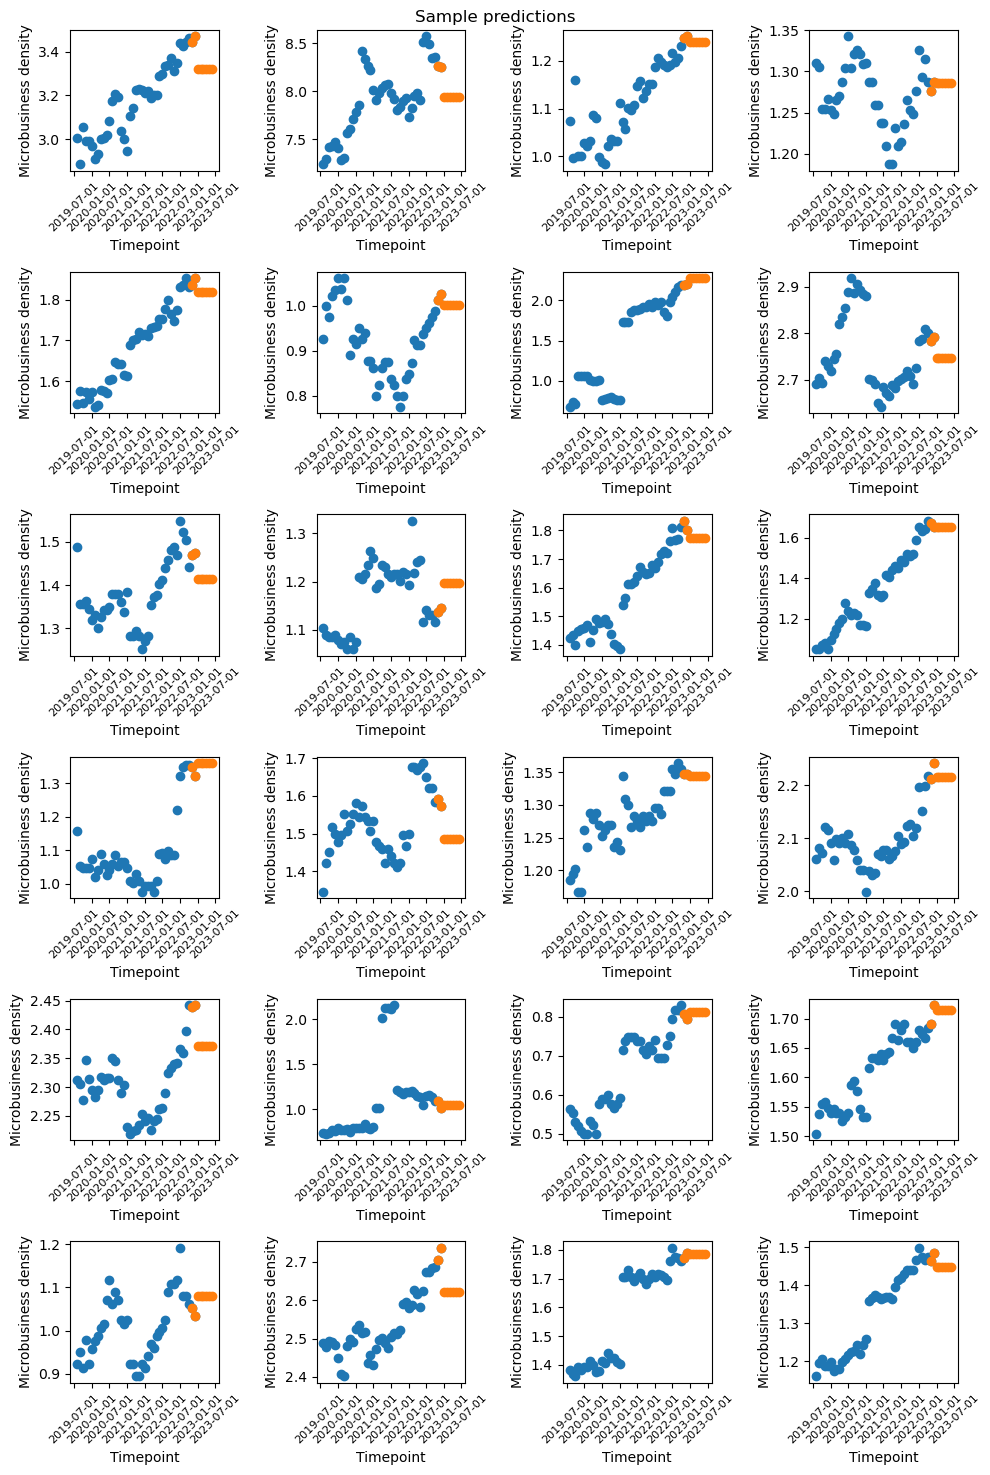

In [13]:
# Get list of counties
cfips = submission_df['cfips']
cfips = cfips.drop_duplicates(keep='first').to_list()

plt = plot_funcs.n_by_n_prediction_scatterplot(
    input_data = training_df,
    predictions = submission_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = list(cfips),
    rows = 6,
    columns = 4,
    fig_height = 15,
    main_title = 'Sample predictions'
)

plt.show()

Not surprisingly, the predictions look terrible. But two things to keep in mind. First, we only ever have to predict a maximum of 4 timepoints, not 8. Second, we are currently only being scored on the first one, which from this distance doesn't look half bad! Let's submit it and see what happens.

In [14]:
# This is what our submission file should look like
sample_submission_df = pd.read_csv(f'{paths.KAGGLE_DATA_PATH}/sample_submission.csv')
print(f'Num rows: {len(sample_submission_df)}')
sample_submission_df.head()

Num rows: 25080


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


In [15]:
# Drop un-needed rows from our prediction so the format matches the sample submission
submission_df.drop(['cfips', 'first_day_of_month', 'county', 'state', 'active'], axis = 1, inplace=True)
print(f'Num rows: {len(submission_df)}')
submission_df.head()

Num rows: 25080


,row_id,microbusiness_density
0,1001_2022-11-01,3.442677
1,1001_2022-12-01,3.470915
2,1001_2023-01-01,3.319231
3,1001_2023-02-01,3.319231
4,1001_2023-03-01,3.319231


<a name="Submission_results"></a>
### 5. Submission and results

In [16]:
# Write csv
output_file = f'{paths.BENCHMARKING_PATH}/2023-02-28_updated_oneshot_naive_model_submission.csv'
submission_df.to_csv(output_file, sep=',', index=False)

**Result**: Submitted to Kaggle 2023-01-31 public leaderboard score 1.0936, placed 1332 of 2029. Not bad for what would have been about 20 minutes of work if we had skipped all of the data exploration!

**Updated result**: Submitted to Kaggle 2023-2-28. Public leaderboard score 1.4631. Placed 693 of 3094. Not bad - thanks for the hint about the census population data correction!